# Autoencoder for MINST

In this assignment you will build, train and apply an autoencoder on the MINST dataset.
Autoencoders are capable of finding a compressed format for an input/output. 
If built with just a linear layer, they will essentially perform PCA, but with nonlinear hidden layers, they can perform additional nonlinear transformation, which might lead to a better compression ratio. 

### Setup
As always, start with importing numpy, matplotlib and tensorflow as you are getting used to

In [2]:
# TODO:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K

### Load training data
We use the fashion part of the MNIST dataset, which is openly available. 
Keras should download it for you automatically

In [3]:
(X_train_full, y_train_full), _ = K.datasets.fashion_mnist.load_data()

# TODO: 
# rescale the grayscale images to have values to be within range 0 to 1
# split the training data into training and validation set by using the last 5000 images as validation set
# name them X_train and X_valid.
X_train_full = tf.convert_to_tensor(X_train_full)
y_train_full = tf.convert_to_tensor(y_train_full)

X_train_full = X_train_full/255
X_valid = X_train_full[-5000:,:,:]
X_train = X_train_full[:-5000,:,:]

n_std = 0.0 # 0 to disable the noise
X_train_full_noise = X_train_full + tf.random.normal(shape=X_train_full.shape, stddev=n_std)
X_train_full_noise = tf.clip_by_value(X_train_full_noise, clip_value_min=0., clip_value_max=1.)
X_valid_noise = X_train_full_noise[-5000:,:,:]
X_train_noise = X_train_full_noise[:-5000,:,:]


A couple utility functions to plot the images:

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
    plt.show()

### Build & Train the autoencoder

We now want to build an autoencoder, e.g. two hidden layers in the encoder and respective decoder, that is able to retain B/W pixels.
For the sizes of the layers, look at the dimension of your input as a reference. \
Figure out the minimum size of the bottleneck such that the rounded_accuracy metric stays just above 93%.  

Check the dimension of your input images. To connect those to your dense layer, you will need to flatten the incoming data inside your model and when reconstructing, to reshape the data to match with the originals.


Think about: 
What will be the input and output of the autoencoder? \
Which loss function is appropriate given the target metric? \
Which activation is appropriate for the output of the decoder?

In [5]:
# pass this measure  as **metric** to your compile function. 
# Metrics are there to help you assess the progress/quality of your training, while not being actively involved in the minimization. 
# This could for example be a dB metric, instead of a 1.234e-4 MSE loss. 
def rounded_accuracy(y_true, y_pred):
    return K.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [6]:
# TODO:
#autoenc_model = 
#autoenc_model.compile(loss=, optimizer=, metrics=)
#hist = autoenc_model.fit(X=, Y=, epochs=10, validation_data=[])

n_hidden = 24
img_shape = X_train.shape[1:]

input_layer = K.Input(img_shape)
flatten_layer = K.layers.Flatten()(input_layer)
hidden_layer_1 = K.layers.Dense(n_hidden, activation=K.activations.relu)(flatten_layer)
hidden_layer_2 = K.layers.Dense(tf.math.reduce_prod(img_shape), activation=K.activations.sigmoid)(hidden_layer_1)
output_layer = K.layers.Reshape(img_shape)(hidden_layer_2)

autoenc_model = K.Model(inputs=input_layer, outputs=output_layer)
autoenc_model.summary()
autoenc_model.compile( 
    optimizer=K.optimizers.Adam(learning_rate=0.001),
    loss=K.losses.MeanSquaredError(),
    metrics=rounded_accuracy)
hist = autoenc_model.fit(x=X_train_noise, y=X_train, epochs=10, shuffle=True, validation_data=(X_valid_noise, X_valid))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 24)                18840     
                                                                 
 dense_1 (Dense)             (None, 784)               19600     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 38,440
Trainable params: 38,440
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1719/1719 [==============================] - 5

1/1 [==============================] - 0s 112ms/step


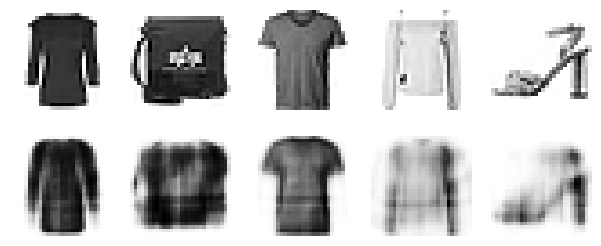

In [7]:
# visualize the output alongside the original images
show_reconstructions(autoenc_model, images=X_valid_noise)

- Try a linear-only auto encoder for reference. Was there really any benefit from having a NN here?
- Evaluate how noise on the input data affects the outcome?
- Find a way to tap into the model and extract the codings. Is there anything meaninful still left?
- Optional: Try replacing some of the layers with convolutional/pooling layers (in the decoder it would need to be deconvolution). Does it affect the performance/complexity?

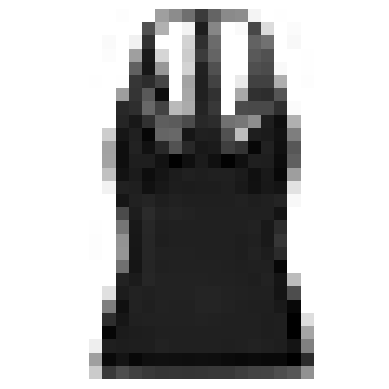

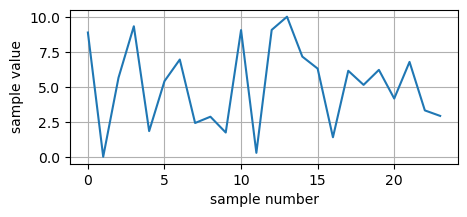

In [47]:
test_image = X_valid[6,:,:]
encode_extractor = K.Model(inputs=autoenc_model.layers[0].input, outputs=autoenc_model.layers[2].output)
encoded_data = encode_extractor(tf.expand_dims(test_image,0))

plot_image(test_image.numpy().squeeze())
plt.figure(figsize=[5,2])
plt.plot(encoded_data.numpy().squeeze())
plt.xlabel('sample number'), plt.ylabel('sample value'), plt.grid()
plt.show()

### AI generated new fashion!
Finally, have some fun and use the decoder as a generator for next-gen fashion by feeding it random codings ;) \
While the result here might look quite crappy, this actually is a use case for the trained decoders: generating even more data. 

1/1 [==============================] - 0s 39ms/step


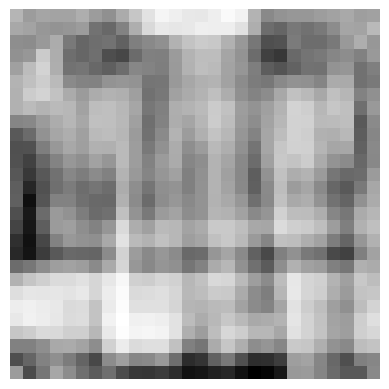

In [172]:
#TODO:
inp_shape_dc = (1,n_hidden)
input_layer_dc = K.Input(n_hidden)
hidden_layer_dc = autoenc_model.layers[3](input_layer_dc)
output_layer_dc = autoenc_model.layers[4](hidden_layer_dc)
decoder_model = K.Model(inputs=input_layer_dc, outputs=output_layer_dc)

rng_avg = 0.5
rng_std = 1
rnd_decoder_inp = tf.random.normal(shape=(1,n_hidden), mean=rng_avg, stddev=rng_std)
#rnd_decoder_inp = tf.random.uniform(shape=(1,n_hidden), minval=0, maxval=1)

generated_img = decoder_model.predict(rnd_decoder_inp)
plot_image(generated_img.squeeze())
